In [1]:
#importing necessary modules
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc
import metpy.plots as mplots
from metpy.units import units
import matplotlib.colors as mplc

In [2]:
#reading in my two data files (first is sliced ERA5 reanalysis on pressure levels, second is 
#sliced ERA5 sfc pressure)
ds = xr.open_dataset('ERA5_1998_katabatic_slice.nc')
sfc_pres_ds = xr.open_dataset('ERA5_1998_pres_slice.nc')
print(ds)
print(sfc_pres_ds)

<xarray.Dataset>
Dimensions:    (latitude: 41, longitude: 41, level: 19, time: 12)
Coordinates:
  * latitude   (latitude) float32 -80.0 -79.75 -79.5 ... -70.5 -70.25 -70.0
  * longitude  (longitude) float32 160.0 160.2 160.5 160.8 ... 169.5 169.8 170.0
  * level      (level) int32 1 3 7 20 50 100 150 ... 750 800 850 900 950 1000
  * time       (time) datetime64[ns] 1997-12-01 1998-01-01 ... 1998-11-01
Data variables:
    r          (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-12-15 04:52:36 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...
<xarray.Dataset>
Dimensions:    (latitude: 41, longitude: 41, time: 12)
Coordinates:
  * latitude   (latitude) float32 -80.0 -79.75 -79.5 ... -70.5 -70.25 -70.0
  * longitude  (longitude) float32 160.0 160.2 160.5

In [3]:
#exploring variables units
print(ds.r.units) #relative humidity units
print(ds.t.units) #temperature units
print(ds.u.units) #zonal wind units
print(ds.v.units) #meridional wind units

%
K
m s**-1
m s**-1


In [4]:
#do the same thing for surface pressure dataset:
#exploring sfc pres units
print(sfc_pres_ds.sp.units) #surface pressure units

Pa


In [5]:
#adding dewpoint as a variable to ds

#dewpoint is calculated from relative humidity and clausius-clapeyron
#RH = e/es * 100%
#e = Aexp[-B/Td]
#es = Aexp[-B/T]

#define the constants:
A = 2.53 * (10 ** 9) #hPa. they cancel out though.
B = 5.42 * (10 ** 3) #K

#T is ds.t

#showing some math for solving for Td:
#RH = 100 * e/es = 100 * exp[-B/Td] / exp[-B/T]
#RH * exp[-B/T] / 100 = exp[-B/Td]
#ln(RH * exp[-B/T] / 100) = -B/Td
#Td = -B/ln(RH * exp[-B/T] / 100) <-- this is the equation I will use to add Td as a new variable

Td = -B/(np.log(ds.r * np.exp(-B/ds.t) / 100))

In [6]:
#sanity check
#testing that Td is accurate before adding it to my dataset

#function for testing on some random indices
def test_dewpoint(time,level,latitude,longitude):
    #all arguments must be an int (ie: must be the index)
    
    #define the dewpoint and temp arrays
    Td_0 = Td[time][level][latitude][longitude].values
    T_0 = ds.t[time][level][latitude][longitude].values
    
    #calculate e and es:
    A = 2.53 * (10 ** 9) #hPa
    B = 5.42 * (10 ** 3) #K
    
    e = A * np.exp(-B/Td_0) #hPa
    es = A * np.exp(-B/T_0) #hPa
    
    #calculate relative humidity
    rh_calculated = e/es * 100
    
    #define actual relative humidity from dataset
    rh_actual = ds.r[time][level][latitude][longitude].values
    
    print('RH calculated:' + str(rh_calculated))
    print('RH real:' + str(rh_actual))
    print(' ')

#testing it on random points
test_dewpoint(10,10,0,0)
test_dewpoint(1,15,30,23)
test_dewpoint(4,5,15,14)

#based on the test points, the calculated relative humidities are accurate to 5-6 significant figures
#these values are close enough for me to say that the calculated dewpoint is very accurate

RH calculated:72.27083538343513
RH real:72.270706
 
RH calculated:76.21102274555928
RH real:76.21094
 
RH calculated:2.4576210783545753
RH real:2.4576209
 


In [7]:
#adding Td to my dataset
ds['td'] = Td

In [8]:
#adding attrs to Td
ds.td.attrs['units'] = 'K'
ds.td.attrs['long_name'] = 'Dewpoint Temperature'

In [9]:
#adding the magnitude of wind speeds as a variable to my dataset
magnitude_v = np.sqrt((ds.u**2)+(ds.v**2))
ds['mag_v'] = magnitude_v
ds.mag_v.attrs['units'] = 'm/s'
ds.mag_v.attrs['long_name'] = 'Magnitude wind speed'

In [10]:
#figuring out min surface pressure in the dry valleys in order to slice the data for anomalies ABOVE THE ICE SHEET
#i don't want to be taking any data from the ice sheet because that will cause inaccuracies in this analysis
pres_slice = sfc_pres_ds.sel(latitude=slice(-79,-76),longitude=slice(161,164))

print(pres_slice.sp.min() / 100) #for hPa

<xarray.DataArray 'sp' ()>
array(767.33789062)


In [11]:
#calculating near-sfc seasonal mean anomalies of temperature, relative humidity, and wind speeds 
#for mcmurdo dry valleys
#mcmurdo dry valleys are located at -77.43 S and 162.3 E

#selecting data at 750hPa and for mcmurdo dry valleys
data_slice = ds.sel(latitude=slice(-79,-76),longitude=slice(161,164),level=750).groupby('time.season').mean('time')

#taking total means
temp_mean = data_slice.t.mean()
rh_mean = data_slice.r.mean()
wind_mean = data_slice.mag_v.mean()


#calculating the seasonal anomalies
#temperature:
t_djf = data_slice.t.sel(season='DJF') - temp_mean #summer
t_mam = data_slice.t.sel(season='MAM') - temp_mean #fall
t_jja = data_slice.t.sel(season='JJA') - temp_mean #winter
t_son = data_slice.t.sel(season='SON') - temp_mean #spring

#relative humidity:
rh_djf = data_slice.r.sel(season='DJF') - rh_mean #summer 
rh_mam = data_slice.r.sel(season='MAM') - rh_mean #fall
rh_jja = data_slice.r.sel(season='JJA') - rh_mean #winter
rh_son = data_slice.r.sel(season='SON') - rh_mean #spring

#wind:
wind_djf = data_slice.mag_v.sel(season='DJF') - wind_mean #summer
wind_mam = data_slice.mag_v.sel(season='MAM') - wind_mean #fall
wind_jja = data_slice.mag_v.sel(season='JJA') - wind_mean #winter
wind_son = data_slice.mag_v.sel(season='SON') - wind_mean #spring

In [12]:
#finding max and mins of anomalies so i know how to set the colorbars

#commenting out the ones that aren't relevant


#finding t anom min:

#print(t_djf.min().values)
print(t_mam.min().values) #lowest at -6
#print(t_jja.min().values) 
#print(t_son.min().values)


#t anom max: 

print(t_djf.max().values) #highest at 6
#print(t_mam.max().values)
#print(t_jja.max().values)
#print(t_son.max().values)


#rh anom min:

#print(rh_djf.min().values)
#print(rh_mam.min().values)
#print(rh_jja.min().values) 
print(rh_son.min().values) #lowest -18


#rh anom max:

print(rh_djf.max().values) #highest 15
#print(rh_mam.max().values)
#print(rh_jja.max().values)
#print(rh_son.max().values)


#wind anom min: 

print(wind_djf.min().values) #lowest -2
#print(wind_mam.min().values)
#print(wind_jja.min().values)
#print(wind_son.min().values)


#wind anom max: 

#print(wind_djf.max().values)
print(wind_mam.max().values) #highest 2.4
#print(wind_jja.max().values)
#print(wind_son.max().values)

-6.0605316162109375
6.4214935302734375
-18.875244140625
15.699573516845703
-2.0106711387634277
2.438112497329712


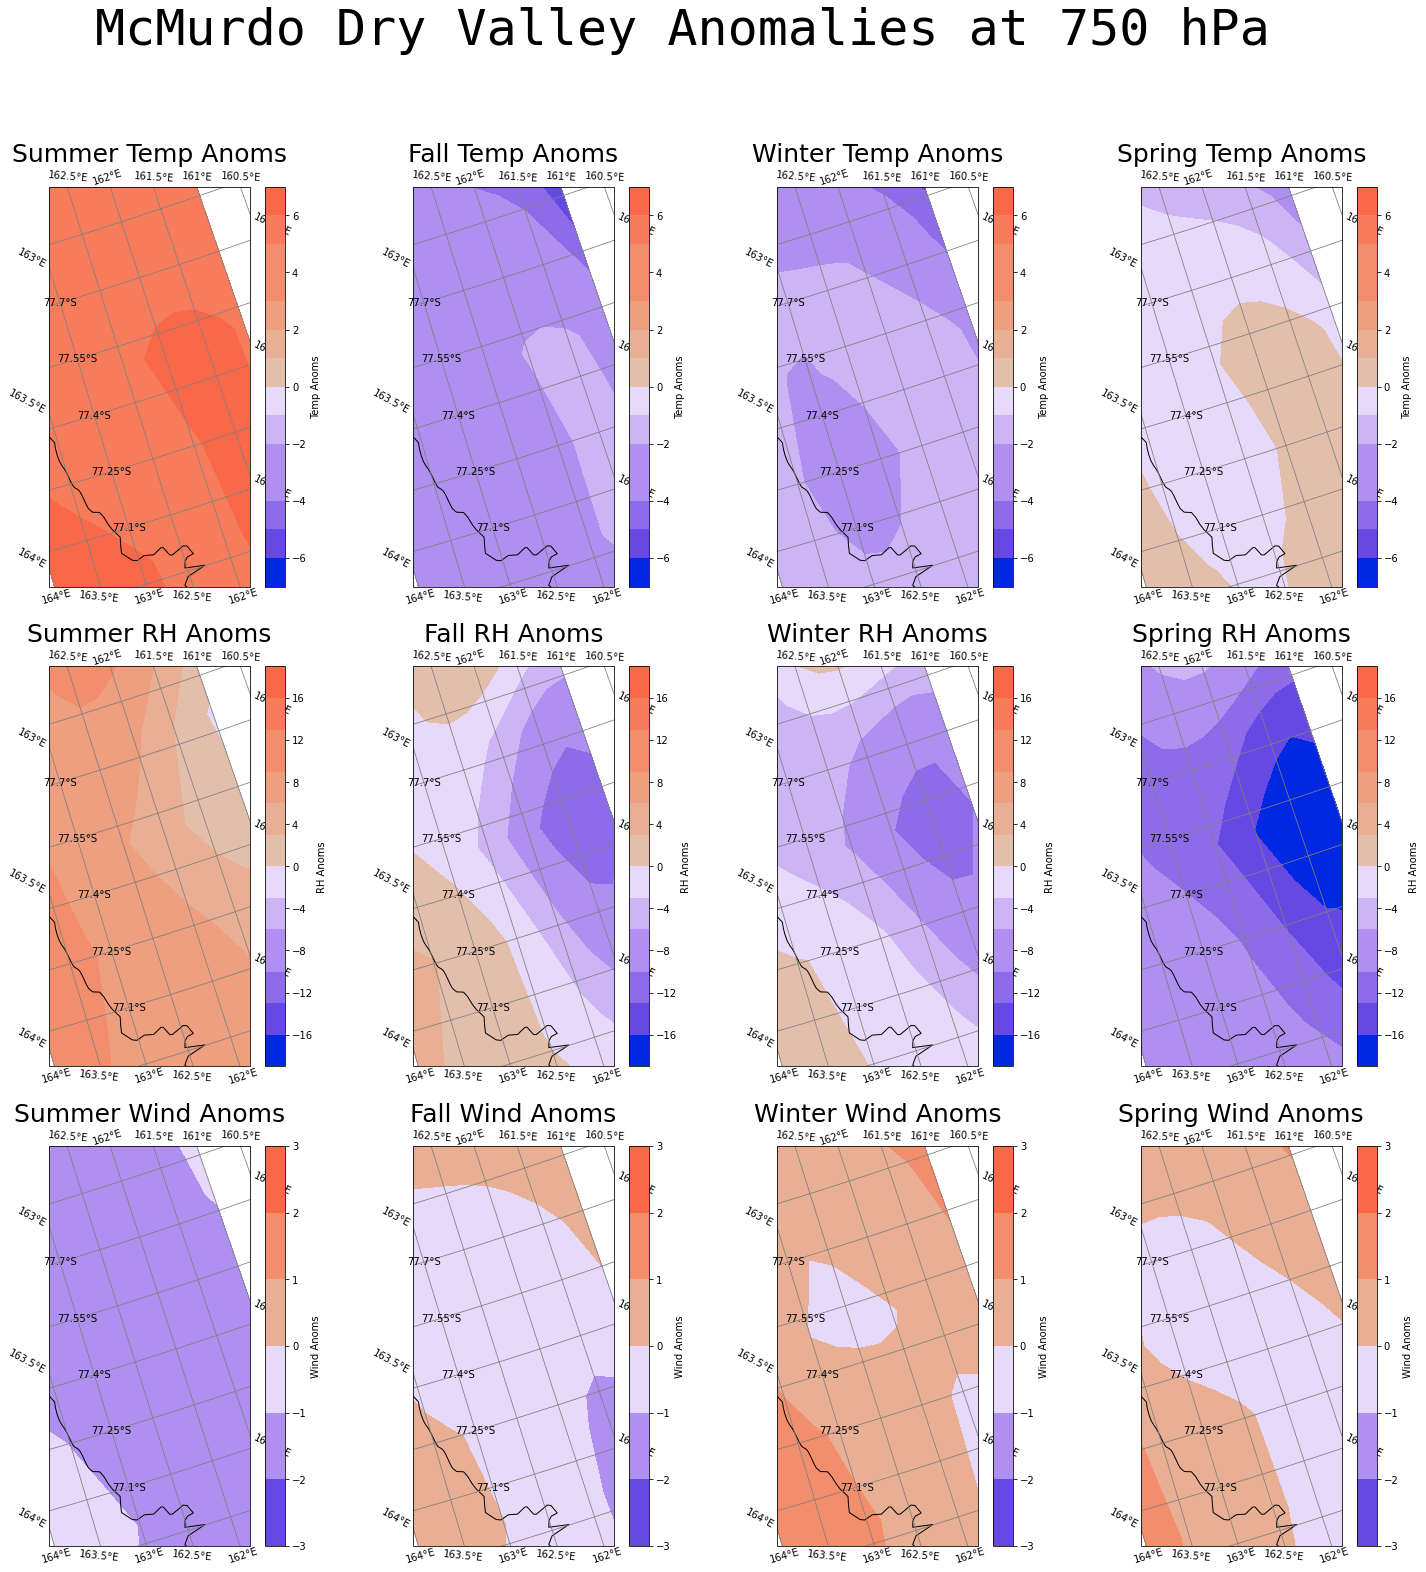

In [13]:
#plotting the anoms:
#set up the fig:
fig = plt.figure(figsize=(25,25))
fig.suptitle('McMurdo Dry Valley Anomalies at 750 hPa',font='Monospace',fontsize=50)


#function to plot the anoms. i'm going to use a loop with this function since it is 12 panels
def plot_the_anoms(fig_index,variable,title,cb_title):
    #fig_index: must be an int 1-12
    #variable: must be an xarray dataarray (ex: t_djf, rh_mam, wind_jja, etc). not a string!
    #title: string of the title
    #cb_title: string of the colorbar label

    #plot the stuff
    cmap = mplc.ListedColormap(['#0027e1','#6649e3','#8e6ce9','#af8fef','#ccb4f5','#e6d9fa','#e3beab','#e9af94','#ee9f80','#f38e6d','#f77c5b','#fa684a'])
    ax = fig.add_subplot(3,4,fig_index,projection=ccrs.SouthPolarStereo())
    ax.coastlines()
    ax.set_extent([161.8,162.8,-77.93,-76.93],ccrs.PlateCarree())
    
    #defining how each colorbar limit should be set
    if cb_title == 'Temp Anoms':
        #temp anom min is ~-6 and temp anom max is ~6 so:
        plot = ax.contourf(data_slice.longitude,data_slice.latitude,variable,
                           transform=ccrs.PlateCarree(),cmap=cmap,levels=np.arange(-7,8,1))
        
    if cb_title == 'RH Anoms':
        #rh anom min is ~-18 and rh anom max is ~15:
        plot = ax.contourf(data_slice.longitude,data_slice.latitude,variable,
                           transform=ccrs.PlateCarree(),cmap=cmap,levels=np.arange(-19,20,1))
        
    if cb_title == 'Wind Anoms':
        #wind anom min is ~-2 and wind anom max is 2.4
        plot = ax.contourf(data_slice.longitude,data_slice.latitude,variable,
                           transform=ccrs.PlateCarree(),cmap=cmap,levels=np.arange(-3,4,1))
    
    plt.colorbar(plot,orientation='vertical',label=cb_title)
    ax.set_title(title,fontsize=25)
    ax.gridlines(color='gray',draw_labels=True)
    
#make 4 lists of indices, variables and titles to iterate over
indices = [1,2,3,4,5,6,7,8,9,10,11,12]
variables = [t_djf, t_mam, t_jja, t_son, rh_djf, rh_mam, rh_jja, rh_son, wind_djf, wind_mam, wind_jja, wind_son]
titles = ['Summer Temp Anoms', 'Fall Temp Anoms','Winter Temp Anoms','Spring Temp Anoms',
             'Summer RH Anoms','Fall RH Anoms','Winter RH Anoms','Spring RH Anoms',
                 'Summer Wind Anoms','Fall Wind Anoms','Winter Wind Anoms','Spring Wind Anoms']
cb_titles = ['Temp Anoms','Temp Anoms','Temp Anoms','Temp Anoms',
                'RH Anoms','RH Anoms','RH Anoms','RH Anoms',
                    'Wind Anoms','Wind Anoms','Wind Anoms','Wind Anoms']

#loop over it and hope it plots. let's see:
for i, j, k, l in zip(indices, variables, titles,cb_titles):
    plot_the_anoms(i,j,k,l)

In [14]:
#changing metpy units of temp and dewpoint to degC & of u and v to kt:
ds['t_degC'] = ds.t.metpy.convert_units(units.degC)
ds['td_degC'] = ds.td.metpy.convert_units(units.degC)
ds['u_kt'] = ds.u.metpy.convert_units(units.knot)
ds['v_kt'] = ds.v.metpy.convert_units(units.knot)

In [15]:
#Take the time mean of each season's vertical profiles
#include temp, dewpoint, and wind speeds

#selecting data at all levels and for mcmurdo dry valleys, grouping by season and taking time means
#lat: 77.43 S
#lon: 162.37 E

data_slice = ds.sel(latitude=slice(-79,-76),longitude=slice(161,164)).groupby('time.season').mean('time')

#note: levels go from 1 hPa to 1000 hPa
#reverse it
data_slice=data_slice.reindex(level=list(reversed(data_slice.level)))

#calculating the seasonal mean vertical profiles for temp, dewpoint, and wind

#temperature:
t_djf = data_slice.t_degC.sel(season='DJF').mean(dim=('latitude','longitude')) #summer
t_jja = data_slice.t_degC.sel(season='JJA').mean(dim=('latitude','longitude')) #winter

#dewpoint:
td_djf = data_slice.td_degC.sel(season='DJF').mean(dim=('latitude','longitude')) #summer
td_jja = data_slice.td_degC.sel(season='JJA').mean(dim=('latitude','longitude')) #winter

#u and v winds:
u_djf = data_slice.u_kt.sel(season='DJF').mean(dim=('latitude','longitude')) #summer
u_jja = data_slice.u_kt.sel(season='JJA').mean(dim=('latitude','longitude')) #winter

v_djf = data_slice.v_kt.sel(season='DJF').mean(dim=('latitude','longitude')) #summer
v_jja = data_slice.v_kt.sel(season='JJA').mean(dim=('latitude','longitude')) #winter

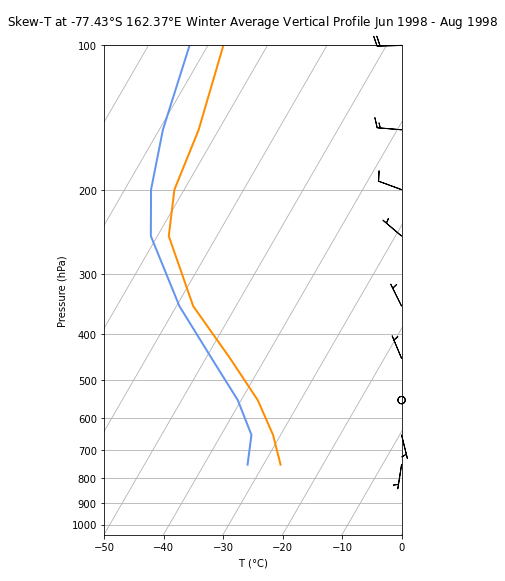

In [16]:
#make two skew-t plots for winter and summer average profiles

#WINTER PLOT - JJA

#Make the figure
fig=plt.figure(figsize=(9, 9))
skew=mplots.SkewT(fig)

#Plot the data
#Start at 750 hPa, which is the 5th index
#winter: jja
skew.plot(data_slice.level[5:], t_jja[5:], 'darkorange', linewidth=2) #plot the air temperature
skew.plot(data_slice.level[5:], td_jja[5:], 'cornflowerblue', linewidth=2) #plot the dewpoint
skew.plot_barbs(data_slice.level[5:],u_jja[5:],v_jja[5:]) #add wind barbs on the side
plt.gca().set_xlim(-50,0)
plt.title('Skew-T at -77.43$\degree$S 162.37$\degree$E Winter Average Vertical Profile Jun 1998 - Aug 1998',pad=20);
plt.xlabel('T ($\degree$C)');
plt.ylabel('Pressure (hPa)');

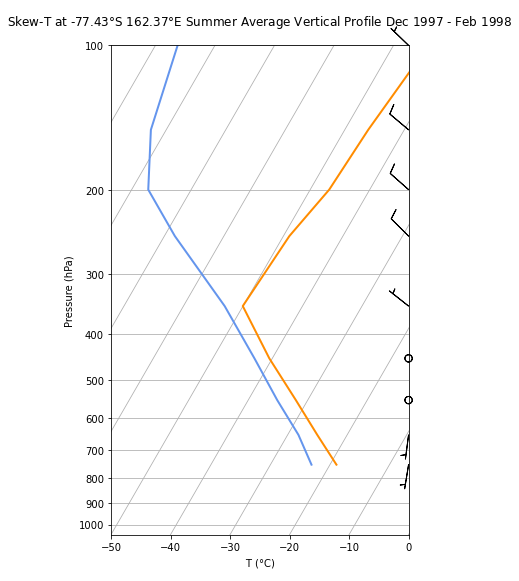

In [17]:
#SUMMER - DJF

#Make the figure
fig=plt.figure(figsize=(9, 9))
skew=mplots.SkewT(fig)

#Plot the data
#summer: djf
skew.plot(data_slice.level[5:], t_djf[5:], 'darkorange', linewidth=2) #plot the air temperature
skew.plot(data_slice.level[5:], td_djf[5:], 'cornflowerblue', linewidth=2) #plot the dewpoint
skew.plot_barbs(data_slice.level[5:],u_djf[5:],v_djf[5:]) #add wind barbs on the side
plt.gca().set_xlim(-50,0)
plt.title('Skew-T at -77.43$\degree$S 162.37$\degree$E Summer Average Vertical Profile Dec 1997 - Feb 1998',pad=20);
plt.xlabel('T ($\degree$C)');
plt.ylabel('Pressure (hPa)');

In [18]:
#Interesting finding that tropopause heights are reverse than what we would think!
#This is supported by research that Antarctica experiences a reverse tropopause height annual cycle
#Zangl and Hoinka (2001) found that the larger the temperature difference is between 100 hPa and 500 hPa, the lower the tropopause pressure and vice versa

#I'll test this by calculating the temperature differences between 100hPa and 550hPa for each of the averages I took for the skew-Ts
#What we should expect: Higher temp diff during winter, Lower temp diff during summer

#100hPa is index 13, 550hPa is index 7


winter_diff = t_jja[7].values - t_jja[13].values #larger temp diff, lower tropopause pressure, cold stratosphere

summer_diff = t_djf[7].values - t_djf[13].values #smaller temp diff, higher tropopause pressure, warm stratosphere

print(winter_diff)
print(summer_diff)

#yay it makes sense!!!!!!
#This means a cold stratosphere is associated with a low tropopause pressure (ie: high tropopause height)
#And a warm stratosphere is associated with a high tropopause pressure (ie: low tropopause height)

40.186565
12.122299


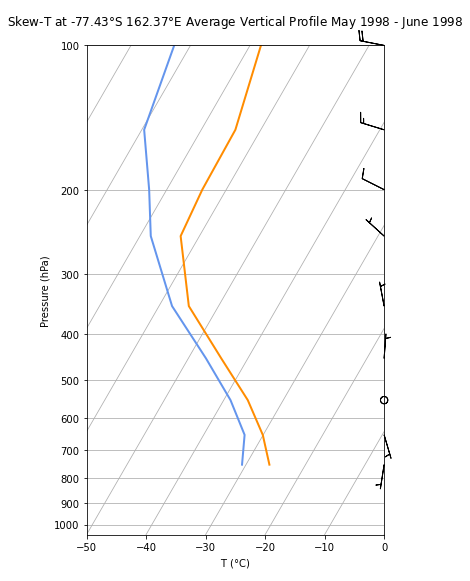

In [19]:
#making a skew-T just for May and June 1998, when the katabatic event occurred

data_slice = ds.sel(latitude=slice(-79,-76),longitude=slice(161,164),time=slice('1998-05-01','1998-06-01')).mean('time')

#note: levels go from 1 hPa to 1000 hPa
#reverse it
data_slice=data_slice.reindex(level=list(reversed(data_slice.level)))

#define the vars
#temperature:
temp = data_slice.t_degC.mean(dim=('latitude','longitude'))

#dewpoint:
dp = data_slice.td_degC.mean(dim=('latitude','longitude'))

#u and v winds:
u = data_slice.u_kt.mean(dim=('latitude','longitude'))
v = data_slice.v_kt.mean(dim=('latitude','longitude'))

#Make the figure
fig=plt.figure(figsize=(9, 9))
skew=mplots.SkewT(fig)

#Plot the data
#summer: djf
skew.plot(data_slice.level[5:], temp[5:], 'darkorange', linewidth=2) #plot the air temperature
skew.plot(data_slice.level[5:], dp[5:], 'cornflowerblue', linewidth=2) #plot the dewpoint
skew.plot_barbs(data_slice.level[5:],u[5:],v[5:]) #add wind barbs on the side
plt.gca().set_xlim(-50,0)
plt.title('Skew-T at -77.43$\degree$S 162.37$\degree$E Average Vertical Profile May 1998 - June 1998',pad=20);
plt.xlabel('T ($\degree$C)');
plt.ylabel('Pressure (hPa)');

In [20]:
#ERA5 not the best for picking up katabatic wind events in the dry valleys
#this data was only monthly averages, perhaps a better resolution could exist with different ERA5 data
#Future work: maybe we could have a better resolution of a katabatic event if we looked at ERA5 average daily or hourly data